In [1]:
# Ensure I don't use any local plugins. Set it to a readable folder with no Python files to avoid warnings.
%env CIS_PLUGIN_HOME=/Users/watson-parris/Pictures

env: CIS_PLUGIN_HOME=/Users/watson-parris/Pictures


# CIS Introduction

CIS has it's own version of the Iris Cube. But it's designed to work with any observational data. The CIS data structure is just called UngriddedData:

<img src="../images/ungridded_data.png" width="640"/>

First unzip your example data to a folder you can easily find it.

In [2]:
from cis import read_data, read_data_list, get_variables

get_variables('../resources/WorkshopData2016/Aeronet/920801_150530_Brussels.lev20')

{'340-440Angstrom',
 '380-500Angstrom',
 '440-675Angstrom',
 '440-675Angstrom(Polar)',
 '440-870Angstrom',
 '500-870Angstrom',
 'AOT_1020',
 'AOT_1640',
 'AOT_340',
 'AOT_380',
 'AOT_412',
 'AOT_440',
 'AOT_443',
 'AOT_490',
 'AOT_500',
 'AOT_531',
 'AOT_532',
 'AOT_551',
 'AOT_555',
 'AOT_667',
 'AOT_675',
 'AOT_870',
 'Date(dd-mm-yy)',
 'Julian_Day',
 'Last_Processing_Date(ddmmyyyy)',
 'Solar_Zenith_Angle',
 'Time(hh:mm:ss)',
 'TripletVar_1020',
 'TripletVar_1640',
 'TripletVar_340',
 'TripletVar_380',
 'TripletVar_412',
 'TripletVar_440',
 'TripletVar_443',
 'TripletVar_490',
 'TripletVar_500',
 'TripletVar_531',
 'TripletVar_532',
 'TripletVar_551',
 'TripletVar_555',
 'TripletVar_667',
 'TripletVar_675',
 'TripletVar_870',
 'Water(cm)',
 'WaterError'}

In [3]:
aeronet_aot_500 = read_data("../resources/WorkshopData2016/Aeronet/920801_150530_Brussels.lev20", "AOT_500")
print(aeronet_aot_500)

Ungridded data: AOT_500 / (1) 
     Shape = (15573,)

     Total number of points = 15573
     Number of non-masked points = 15573
     Long name = AOT_500
     Standard name = None
     Units = 1
     Missing value = -999.0
     Range = (0.01864, 1.4709920000000001)
     History = 
     Coordinates: 
       Longitude
          Long name = 
          Standard name = longitude
          Units = degrees_east
          Missing value = None
          Range = (4.3499999999999996, 4.3499999999999996)
          History = 
       Latitude
          Long name = 
          Standard name = latitude
          Units = degrees_north
          Missing value = None
          Range = (50.783000000000001, 50.783000000000001)
          History = 
       Altitude
          Long name = 
          Standard name = altitude
          Units = meters
          Missing value = None
          Range = (120.0, 120.0)
          History = 
       DateTime
          Long name = 
          Standard name = time
        

In [4]:
aeronet_aot_500.name()

'AOT_500'

## Some example datasets

In [5]:
%matplotlib inline

### Ungridded time series data

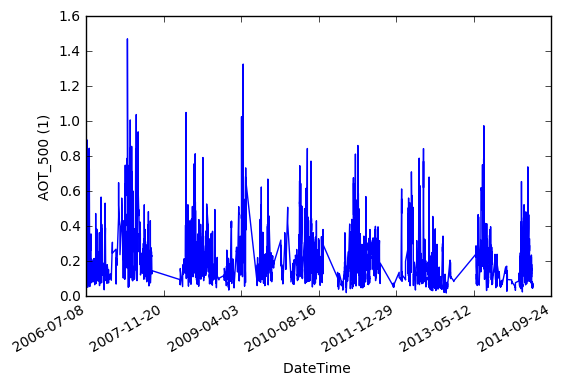

In [6]:
aeronet_aot_500.plot()

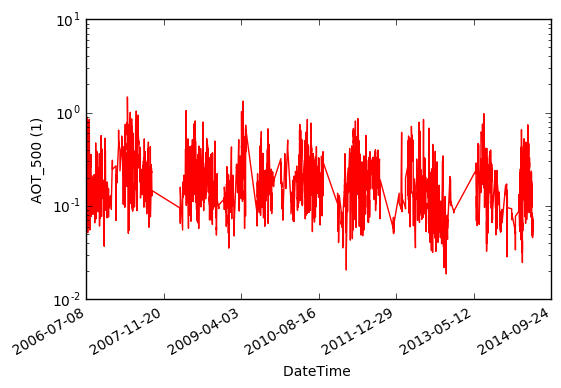

In [7]:
ax = aeronet_aot_500.plot(color='red')
ax.set_yscale('log')

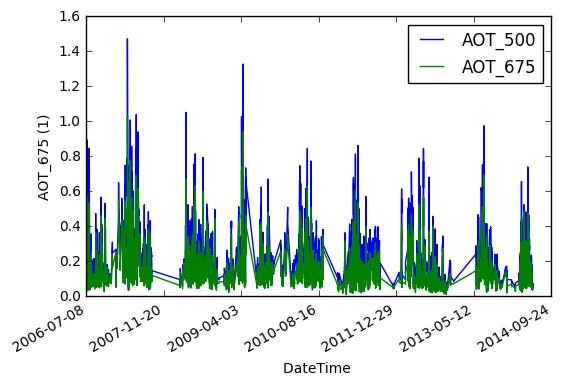

In [8]:
aeronet_aot = read_data_list("../resources/WorkshopData2016/Aeronet/920801_150530_Brussels.lev20", 
                             ['AOT_500', 'AOT_675'])
ax = aeronet_aot.plot()

In [9]:
ax.set_title('Brussels Aeronet AOT')
ax.set_xlabel('Date')

In [10]:
from datetime import datetime 
ax.set_xlim(datetime(2007,5,5), datetime(2007,8,26))    

(732801.0, 732914.0)

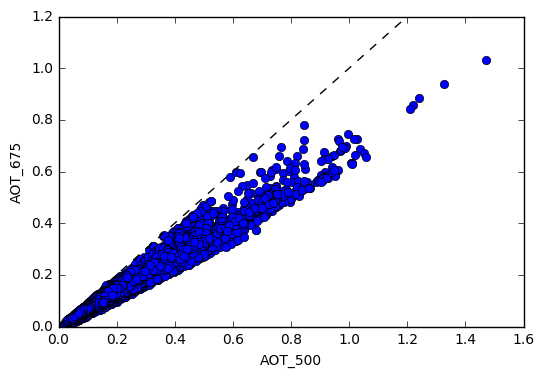

In [11]:
aeronet_aot.plot(how='comparativescatter')
# Note that this will only work if we have two datasets in our list

### Subsetting

CIS is able to `subset` datasets across any of the given coordinates

In [12]:
aeronet_aot_2007 = aeronet_aot.subset(t=[datetime(2007,1,1), datetime(2007,12,31)])
aeronet_aot_2007

[<cis 'UngriddedData' of Ungridded data: AOT_500 / (1) 
>,
<cis 'UngriddedData' of Ungridded data: AOT_675 / (1) 
>]

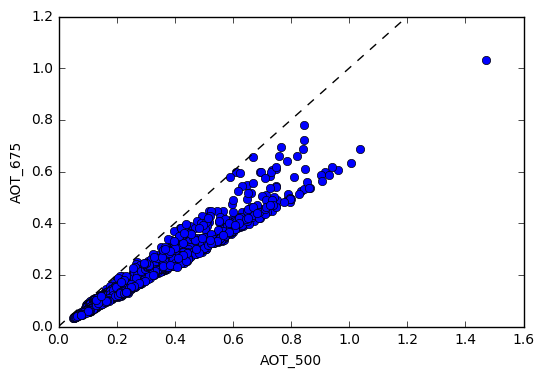

In [13]:
aeronet_aot_2007.plot(how='comparativescatter')

### Model time series

In [14]:
model_aod = read_data("../resources/WorkshopData2016/od550aer.nc", "od550aer")

In [15]:
print(model_aod)

od550aer / (1)                      (time: 1464; latitude: 96; longitude: 192)
     Dimension coordinates:
          time                           x               -              -
          latitude                       -               x              -
          longitude                      -               -              x
     Attributes:
          CDI: Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.0
          advection: Lin & Rood
          date_time: 20140613 051140
          echam_version: 6.1.00
          grid_type: gaussian
          history: Fri Dec 04 17:15:40 2015: cdo -r copy od550aer.nc ../../temp.nc
Tue Jul...
          host_name: p101
          institution: Max-Planck-Institute for Meteorology
          jsbach_version: 2.01
          operating_system: AIX 6.1 Power6
          physics: Modified ECMWF physics
          radiation: Modified ECMWF rad

In [16]:
import iris.analysis
maod_global_mean, = model_aod.collapsed(['longitude', 'latitude'], iris.analysis.MEAN)

/Users/watson-parris/anaconda/envs/python_workshop/lib/python3.5/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [17]:
print(maod_global_mean)

od550aer / (1)                      (time: 1464)
     Dimension coordinates:
          time                           x
     Scalar coordinates:
          latitude: 0.0 degrees, bound=(-89.4969872937, 89.4969872937) degrees
          longitude: 179.0625 degrees, bound=(-0.9375, 359.0625) degrees
     Attributes:
          CDI: Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.0
          advection: Lin & Rood
          date_time: 20140613 051140
          echam_version: 6.1.00
          grid_type: gaussian
          history: Fri Dec 04 17:15:40 2015: cdo -r copy od550aer.nc ../../temp.nc
Tue Jul...
          host_name: p101
          institution: Max-Planck-Institute for Meteorology
          jsbach_version: 2.01
          operating_system: AIX 6.1 Power6
          physics: Modified ECMWF physics
          radiation: Modified ECMWF radiation
          title: AEROCOM


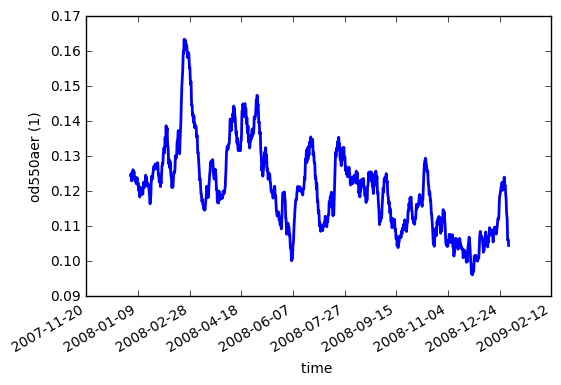

In [18]:
ax = maod_global_mean.plot(itemwidth=2)

In [19]:
aeronet_aot_500.plot(ax=ax)

### Aircraft data

In [20]:
number_concentration = read_data('../resources/WorkshopData2016/ARCPAC_2008', 
                                 'NUMBER_CONCENTRATION')
print(number_concentration)

Ungridded data: NUMBER_CONCENTRATION / (#/cm3) 
     Shape = (1268,)

     Total number of points = 1268
     Number of non-masked points = 981
     Long name = 
     Standard name = None
     Units = #/cm3
     Missing value = -9999
     Range = (17.0, 2191.0)
     History = 
     Misc attributes: 
       Missing_Value = -9999
     Coordinates: 
       TIME
          Long name = 
          Standard name = time
          Units = days since 1600-01-01 00:00:00
          Missing value = -9999
          Range = (2008-04-11 20:01:30, 2008-04-16 03:03:30)
          History = 
          Misc attributes: 
            Missing_Value = -9999
       LATITUDE
          Long name = 
          Standard name = latitude
          Units = degrees
          Missing value = -9999
          Range = (63.303199999999997, 75.128600000000006)
          History = 
          Misc attributes: 
            Missing_Value = -9999
       LONGITUDE
          Long name = 
          Standard name = longitude
          

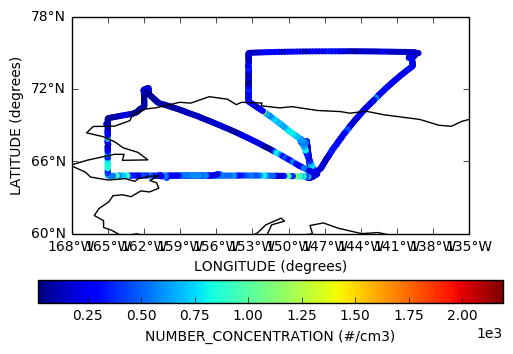

In [21]:
ax = number_concentration.plot()

In [22]:
ax.bluemarble()

### Satellite data

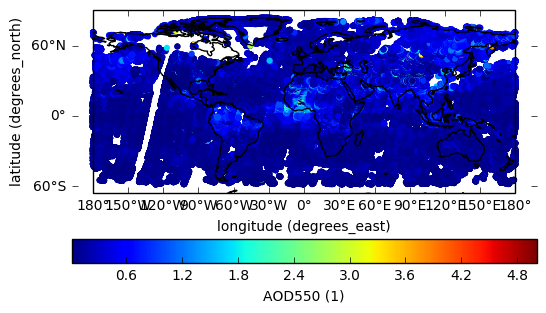

In [23]:
aerosol_cci = read_data('../resources/WorkshopData2016/AerosolCCI', 
                        'AOD550')
aerosol_cci.plot()

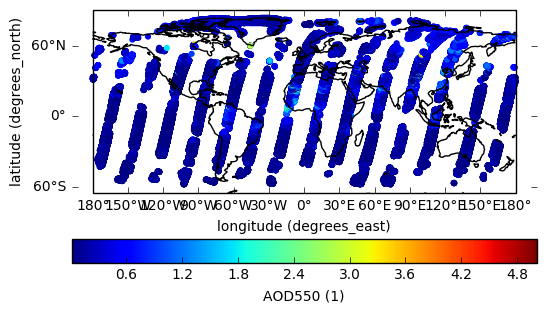

In [24]:
aerosol_cci_one_day = read_data('../resources/WorkshopData2016/AerosolCCI/20080415*.nc', 
                                'AOD550')
ax = aerosol_cci_one_day.plot()

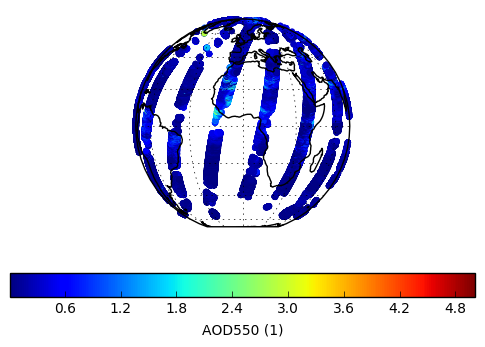

In [25]:
aerosol_cci_one_day.plot(projection='Orthographic')

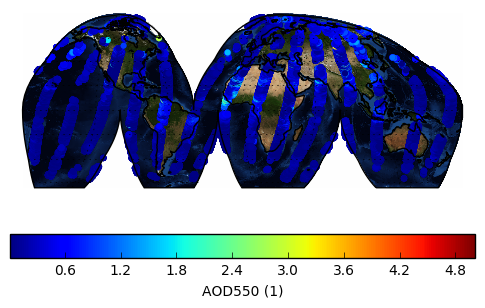

In [26]:
ax=aerosol_cci_one_day.plot(projection='InterruptedGoodeHomolosine')
ax.bluemarble()

## Aggregation

Given a set of UngriddedData...

<img src="../images/ungridded_aggregation_1.png" width="640"/>

... we can perform an aggregation over a specified grid...

<img src="../images/ungridded_aggregation_2.png" width="640"/>

... to create a new GriddedData object (which is essentiall an Iris Cube)

<img src="../images/ungridded_aggregation_3.png" width="640"/>

In [27]:
gridded_aerosol_cci_one_day = aerosol_cci_one_day.aggregate(x=[-180,180,10], y=[-90,90,5])

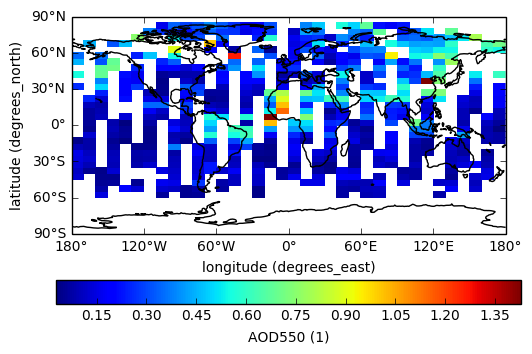

In [28]:
gridded_aerosol_cci_one_day[0].plot()

## Exercises

**1.** Read in ``AOD550`` and ``AOD670`` from the 5 days of satellite data 

**2.** Subset this data down to the region covered by the aircraft data

**3.** Try plotting ``AOD550`` against ``AOD670`` from the subsetted satellite data using a comparative scatter plot


## Collocation

<img src="../images/collocation_options.png" width="640"/>

### Model onto Aeronet

<img src="../images/model_onto_aeronet.png" width="640"/>

This is an gridded onto un-gridded collocation and can be done using either linear interpolation or nearest neighbour.

This is very quick and in general CIS can even handle hybrid height coordinates: 

<img src="../images/gridded_ungridded_collocation.png" width="640"/>

In [29]:
# Lets take a closer look at the model data
print(model_aod)

od550aer / (1)                      (time: 1464; latitude: 96; longitude: 192)
     Dimension coordinates:
          time                           x               -              -
          latitude                       -               x              -
          longitude                      -               -              x
     Attributes:
          CDI: Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.0
          advection: Lin & Rood
          date_time: 20140613 051140
          echam_version: 6.1.00
          grid_type: gaussian
          history: Fri Dec 04 17:15:40 2015: cdo -r copy od550aer.nc ../../temp.nc
Tue Jul...
          host_name: p101
          institution: Max-Planck-Institute for Meteorology
          jsbach_version: 2.01
          operating_system: AIX 6.1 Power6
          physics: Modified ECMWF physics
          radiation: Modified ECMWF rad

In [30]:
from cis.time_util import PartialDateTime
# First subset the aeronet data:
aeronet_aot_2008 = aeronet_aot_500.subset(t=PartialDateTime(2008))

Note that we don’t actually have to do this subsetting, but that otherwise CIS will interpolate the nearest values, which in this case we don’t really want.

In [31]:
# Now do the collocation:
model_aod_onto_aeronet = model_aod.collocated_onto(aeronet_aot_2008)

/Users/watson-parris/anaconda/envs/python_workshop/lib/python3.5/site-packages/cis/collocation/gridded_interpolation.py:181: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  expanded_result[~self.missing_mask] = result


In [32]:
print(model_aod_onto_aeronet[0])

Ungridded data: od550aer / (1) 
     Shape = (1885,)

     Total number of points = 1885
     Number of non-masked points = 1885
     Long name = Optical thickness - total 550nm
     Standard name = None
     Units = 1
     Missing value = nan
     Range = (0.02192891966422272, 1.6932252635449034)
     History = 2016-12-07T11:53:21Z Collocated onto sampling from: [] 
using CIS version 1.5.1 
variables: od550aer 
with files: ['../resources/WorkshopData2016/od550aer.nc'] 
using collocator: <cis.collocation.col_implementations.GriddedUngriddedCollocator object at 0x11041bf60> 
kernel: lin
     Coordinates: 
       Longitude
          Long name = 
          Standard name = longitude
          Units = degrees_east
          Missing value = None
          Range = (4.3500000000000227, 4.3500000000000227)
          History = 
       Latitude
          Long name = 
          Standard name = latitude
          Units = degrees_north
          Missing value = None
          Range = (50.78300000000

Note the updated history

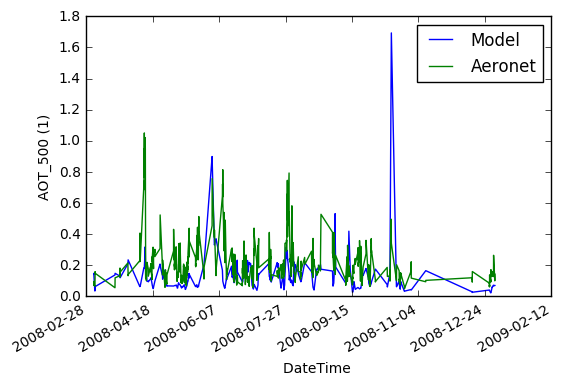

In [33]:
from cis.plotting.plot import multilayer_plot, taylor_plot
ax = multilayer_plot([model_aod_onto_aeronet[0], aeronet_aot_2008], 
                     layer_opts=[dict(label='Model'), 
                                 dict(label='Aeronet')], xaxis='time',
                    itemwidth=1)

(<cis.plotting.taylor.Taylor at 0x118674940>,
 <matplotlib.axes._subplots.Floating AxesHostAxesSubplot at 0x11aaac9e8>)

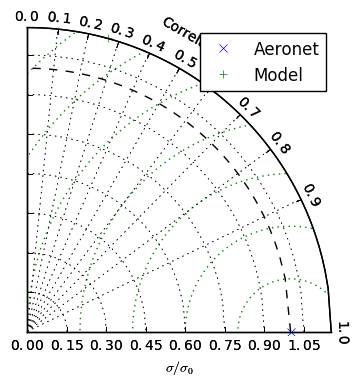

In [34]:
taylor_plot([aeronet_aot_2008, model_aod_onto_aeronet[0]], 
            layer_opts=[dict(label='Aeronet'),dict(label='Model')])

In [35]:
# Basic maths on the data
print(model_aod_onto_aeronet[0] - aeronet_aot_2008)

Ungridded data: od550aer / (1) 
     Shape = (1885,)

     Total number of points = 1885
     Number of non-masked points = 1885
     Long name = Optical thickness - total 550nm
     Standard name = None
     Units = 1
     Missing value = nan
     Range = (-0.86902314968727379, 1.3514322635449034)
     History = 2016-12-07T11:53:21Z Collocated onto sampling from: [] 
using CIS version 1.5.1 
variables: od550aer 
with files: ['../resources/WorkshopData2016/od550aer.nc'] 
using collocator: <cis.collocation.col_implementations.GriddedUngriddedCollocator object at 0x11041bf60> 
kernel: lin
2016-12-07T11:53:22Z Performed unary_func operation
     Coordinates: 
       Longitude
          Long name = 
          Standard name = longitude
          Units = degrees_east
          Missing value = None
          Range = (4.3500000000000227, 4.3500000000000227)
          History = 
       Latitude
          Long name = 
          Standard name = latitude
          Units = degrees_north
          M

### Aircraft onto satellite

<img src="../images/aircraft_onto_satellite.png" width="640"/>

As you can see the difficulty here is the sparseness of the aircraft data, and actually of the satellite data in this region.

This is an ungridded to ungridded collocation:

<img src="../images/ungridded_ungridded_collocation.png" width="640" />

In [36]:
# Read all of the AOD satelite variables
aerosol_cci = read_data_list('../resources/WorkshopData2016/AerosolCCI', 'AOD*0')
aoerosol_cci_Alaska = aerosol_cci.subset(x=[-170,-100],y=[35,80])

In [37]:
print(aerosol_cci)

UngriddedDataList: 
0: Ungridded data: AOD550 / (1) 
1: Ungridded data: AOD1600 / (1) 
2: Ungridded data: AOD670 / (1) 
3: Ungridded data: AOD870 / (1) 
Coordinates: 
  longitude
  latitude
  time



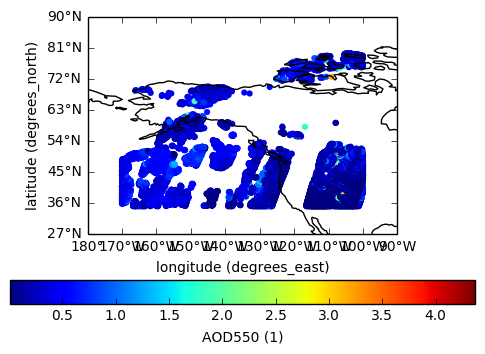

In [38]:
aoerosol_cci_Alaska[0].plot(yaxis='latitude')

In [39]:
aerosol_cci_collocated = aoerosol_cci_Alaska.collocated_onto(number_concentration, 
                                                             h_sep=10, t_sep='P1D')

/Users/watson-parris/anaconda/envs/python_workshop/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/watson-parris/anaconda/envs/python_workshop/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
aerosol_cci_collocated.append(number_concentration)
print(aerosol_cci_collocated)

UngriddedDataList: 
0: Ungridded data: AOD550 / (1) 
1: Ungridded data: AOD550_std_dev / (1) 
2: Ungridded data: AOD550_num_points / (unknown) 
3: Ungridded data: AOD1600 / (1) 
4: Ungridded data: AOD1600_std_dev / (1) 
5: Ungridded data: AOD1600_num_points / (unknown) 
6: Ungridded data: AOD670 / (1) 
7: Ungridded data: AOD670_std_dev / (1) 
8: Ungridded data: AOD670_num_points / (unknown) 
9: Ungridded data: AOD870 / (1) 
10: Ungridded data: AOD870_std_dev / (1) 
11: Ungridded data: AOD870_num_points / (unknown) 
12: Ungridded data: NUMBER_CONCENTRATION / (#/cm3) 
Coordinates: 
  TIME
  LATITUDE
  LONGITUDE
  ALTITUDE



In [41]:
aerosol_cci_collocated = aerosol_cci_collocated[::3]

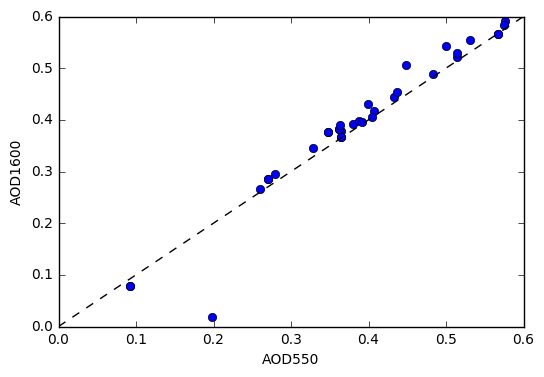

In [42]:
aerosol_cci_collocated[:2].plot('comparativescatter')

## Exercises

**1.** How does the correlation change if we only include those average number concentrations which averaged more than one point?

**2.** Consider the case of comparing our model AOD with the AerosolCCI.

**a.** What strategies could you employ?
    
**b.** Perform an initial assesment of the model AOD field using the Aerosol CCI data for the few days we have data.

## CIS and Pandas

In [43]:
df = aerosol_cci_collocated.as_data_frame()
print(df)

                     ALTITUDE  LATITUDE  LONGITUDE    AOD550   AOD1600  \
2008-04-11 20:01:30     233.4   64.8029  -147.8828  0.270871  0.284781   
2008-04-11 20:02:30     652.9   64.7594  -147.9471  0.279516  0.294635   
2008-04-11 20:03:30    1099.1   64.7385  -148.0415  0.328403  0.345198   
2008-04-11 20:04:30    1496.7   64.7820  -148.1129  0.379837  0.391794   
2008-04-11 20:05:30    1877.5   64.8434  -148.1207  0.432696  0.443872   
2008-04-11 20:06:30    2245.8   64.9073  -148.1275  0.514773  0.520862   
2008-04-11 20:07:30    2638.7   64.9720  -148.1360  0.483544  0.489666   
2008-04-11 20:08:30    3013.7   65.0354  -148.1538  0.260520  0.265527   
2008-04-11 20:09:30    3275.1   65.1007  -148.1691  0.407154  0.416466   
2008-04-11 20:10:30    3411.1   65.1700  -148.1806  0.387216  0.397496   
2008-04-11 20:11:30    3412.2   65.2419  -148.1874  0.513911  0.529464   
2008-04-11 20:12:30    3410.5   65.3126  -148.1910  0.447898  0.506485   
2008-04-11 20:13:30    3412.0   65.382

In [44]:
df.corr()
# Then do a pretty plot of it...
# This is a nice segway into the Pandas lesson.

,ALTITUDE,LATITUDE,LONGITUDE,AOD550,AOD1600,AOD670,AOD870,NUMBER_CONCENTRATION
ALTITUDE,1.000000,-0.371033,-0.036407,0.008630,-0.042618,-0.042618,-0.083855,0.518533
LATITUDE,-0.371033,1.000000,0.171710,-0.077648,-0.169449,-0.169449,-0.175468,-0.433387
LONGITUDE,-0.036407,0.171710,1.000000,0.483901,0.515622,0.515622,0.404065,-0.011983
AOD550,0.008630,-0.077648,0.483901,1.000000,0.970247,0.970247,0.909970,-0.320531
AOD1600,-0.042618,-0.169449,0.515622,0.970247,1.000000,1.000000,0.846541,-0.344245
AOD670,-0.042618,-0.169449,0.515622,0.970247,1.000000,1.000000,0.846541,-0.344245
AOD870,-0.083855,-0.175468,0.404065,0.909970,0.846541,0.846541,1.000000,-0.295922
NUMBER_CONCENTRATION,0.518533,-0.433387,-0.011983,-0.320531,-0.344245,-0.344245,-0.295922,1.000000


In [45]:
# Save the collocation output so that we can come back to it during the Pandas tutorial.
aerosol_cci_collocated.save_data('col_output.nc')